<a href="https://colab.research.google.com/github/JFrankVC/aprendizaje_profundo/blob/main/Feuilles_Grey_densenet_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name: *José Francisco Villanueva Cortés*
# Dossier: *742015*

In [ ]:
# imports
import torch.nn as nn
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import torch
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights, alexnet, AlexNet_Weights
from tqdm import tqdm

In [ ]:
# Utilities
WHITE = '\033[97m'
YELLOW = '\033[93m'
BLUE = '\033[94m'
GREEN = '\033[92m'
RED = '\033[91m'
RESET = '\033[0m'

mean_calculation = False
training_mode = True
individual_testing = False
group_testing = not individual_testing

In [ ]:
# Connect drive to verify model storage
# Mount the Google Drive
# Allow access - check steps and methods in: https://neptune.ai/blog/google-colab-dealing-with-files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # if Colab root directory is shown, go to /content folder

Mounted at /content/drive


In [ ]:
# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

# Change the directory - Google Drive
path = "/content/drive/MyDrive/Colab_DL/Data_DL/Feuilles/Greyscale/test/grayscale"
os.chdir(path)

# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

Current working directory /content
Current working directory /content/drive/MyDrive/Colab_DL/Data_DL/Feuilles/Greyscale/test/grayscale


## Get/read/generate data

In [ ]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop(224),
            transforms.Resize([256,256]),
            transforms.RandomVerticalFlip(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.Grayscale(num_output_channels=1),
        ])

In [ ]:
if mean_calculation:
    def get_mean_std(loader):
        # Compute the mean and standard deviation of all pixels in the dataset
        num_pixels = 0
        mean = 0.0
        std = 0.0
        for images, _ in loader:
            batch_size, num_channels, height, width = images.shape
            num_pixels += batch_size * height * width
            mean += images.mean(axis=(0, 2, 3)).sum()
            std += images.std(axis=(0, 2, 3)).sum()

        mean /= num_pixels
        std /= num_pixels

        return mean, std

In [ ]:
if mean_calculation:
    def batch_mean_and_sd(loader):

        cnt = 0
        fst_moment = torch.empty(3)
        snd_moment = torch.empty(3)

        for images, _ in loader:
            b, c, h, w = images.shape
            nb_pixels = b * h * w
            sum_ = torch.sum(images, dim=[0, 2, 3])
            sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
            fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
            snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
            cnt += nb_pixels

        mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

        return mean,std

In [ ]:
data = ImageFolder(root=path)

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=5, shuffle=True, num_workers=1)

In [ ]:
if mean_calculation:
    mean, std = get_mean_std(data_loader)
    print(f"Mean: {mean}, Std: {std}")

In [ ]:
if mean_calculation:
    mean, std = batch_mean_and_sd(data_loader)
    print(f"Mean: {mean}, Std: {std}")

In [ ]:
a = data.loader(data.imgs[1][0])

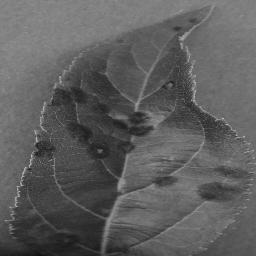

In [ ]:
a

In [ ]:
a = transform(a)

In [ ]:
a

tensor([[[ 0.0695,  0.1260,  0.1869,  ...,  0.1434,  0.1977,  0.2260],
         [ 0.2108,  0.2443,  0.2804,  ...,  0.1531,  0.1977,  0.2260],
         [ 0.2911,  0.3000,  0.3095,  ...,  0.1673,  0.2074,  0.2260],
         ...,
         [-0.9115, -0.9627, -1.0417,  ..., -0.5069, -0.4954, -0.4813],
         [-0.9104, -0.9757, -1.0677,  ..., -0.4802, -0.4781, -0.4693],
         [-1.1646, -1.2070, -1.2646,  ..., -0.4519, -0.4552, -0.4693]]])

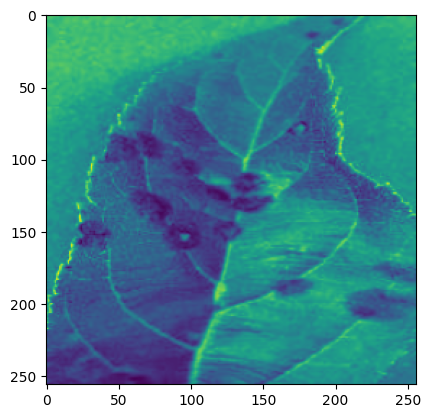

In [ ]:
# prtin image
plt.imshow(a.permute(1, 2, 0))

In [ ]:
# Function to receive data and get classes
def get_species(data_classes):
    classes = []
    for i in range(len(data_classes)):
        # Get string before comma or underscore
        temp = data_classes[i].split(',')[0]
        temp = data_classes[i].split('_')[0]

        if temp not in classes:
            classes.append(temp)

    # Convert to uppercase
    classes = [c.upper() for c in classes]
    #print(len(classes))

    # Eliminate duplicates
    classes = list(set(classes))
    print(len(classes))

    return classes

# Function to receive data and get healthy or disease
def get_healthiness(data_classes):
    healthy = []
    for i in range(len(data_classes)):
        # Get string after comma or underscore
        temp = data_classes[i].split('__')[1]
        if 'Tomato' in temp:
            temp = temp.split('Tomato')[1]
        if 'apple' in temp:
            temp = temp.split('apple')[1]
        if temp not in healthy:
            #temp = temp.split('_')[1]
            temp = temp[1:]
            healthy.append(temp)

    # Convert to uppercase
    healthy = [h.upper() for h in healthy]
    #print(len(healthy))

    # Eliminate duplicates
    healthy = list(set(healthy))
    print(len(healthy))

    return healthy


In [ ]:
# Get classes, species (s) and diseases/healthy (h)
s = get_species(data.classes)
h = get_healthiness(data.classes)

14
21


In [ ]:
s, h

(['CORN',
  'APPLE',
  'STRAWBERRY',
  'PEACH',
  'SOYBEAN',
  'BLUEBERRY',
  'TOMATO',
  'ORANGE',
  'PEPPER,',
  'POTATO',
  'RASPBERRY',
  'SQUASH',
  'CHERRY',
  'GRAPE'],
 ['BACTERIAL_SPOT',
  'LEAF_MOLD',
  'MOSAIC_VIRUS',
  'RUST',
  'POWDERY_MILDEW',
  'YELLOW_LEAF_CURL_VIRUS',
  'LEAF_SCORCH',
  'CERCOSPORA_LEAF_SPOT GRAY_LEAF_SPOT',
  'TARGET_SPOT',
  'COMMON_RUST_',
  'HAUNGLONGBING_(CITRUS_GREENING)',
  'BLACK_ROT',
  'NORTHERN_LEAF_BLIGHT',
  'SEPTORIA_LEAF_SPOT',
  'LEAF_BLIGHT_(ISARIOPSIS_LEAF_SPOT)',
  'EARLY_BLIGHT',
  'LATE_BLIGHT',
  'ESCA_(BLACK_MEASLES)',
  'HEALTHY',
  'SPIDER_MITES TWO-SPOTTED_SPIDER_MITE',
  'APPLE_SCAB'])

In [ ]:
# From s get index where 'TOMATO' is
# index to be used for weighting unbalanced class with so many samples
for i in range(len(s)):
    if 'TOMATO' in s[i]:
        TOMATO_idx = i
        break
print(TOMATO_idx)

6


In [ ]:
# From s get index where 'RASPBERRY' is
# index to be used for weighting unbalanced class with so few samples
for i in range(len(s)):
    if 'RASPBERRY' in s[i]:
        RASPBERRY_idx = i
        break
print(RASPBERRY_idx)

10


In [ ]:
# Count number of datapoints per class
list_classes = get_species(data.classes)
list_datapoints = []
for i in range(len(list_classes)):
    count = 0
    for label in range(len(data.imgs)):
        if (list_classes[i].lower() in data.imgs[label][0] or list_classes[i].lower().title() in data.imgs[label][0]) :
            count += 1
    list_datapoints.append(count)
    #datapoints_per_class = len(data.imgs)

    print(f"Class {i}: {list_classes[i]}\nDatapoints: {list_datapoints[i]}")
print(f"Total datapoints: {np.sum(list_datapoints)}")

14
Class 0: CORN
Datapoints: 3882
Class 1: APPLE
Datapoints: 3171
Class 2: STRAWBERRY
Datapoints: 1565
Class 3: PEACH
Datapoints: 2707
Class 4: SOYBEAN
Datapoints: 5090
Class 5: BLUEBERRY
Datapoints: 1522
Class 6: TOMATO
Datapoints: 18210
Class 7: ORANGE
Datapoints: 5507
Class 8: PEPPER,
Datapoints: 2507
Class 9: POTATO
Datapoints: 2152
Class 10: RASPBERRY
Datapoints: 371
Class 11: SQUASH
Datapoints: 1873
Class 12: CHERRY
Datapoints: 1954
Class 13: GRAPE
Datapoints: 4062
Total datapoints: 54573


In [ ]:
# Create dict for mapping class to number of datapoints
dict_classes_dtpts = {}
for i in range(len(list_classes)):
    dict_classes_dtpts[list_classes[i]] = list_datapoints[i]

In [ ]:
# Create dict to map class index to species
dict_classes_species = {}
for i in range(len(list_classes)):
    dict_classes_species[i] = list_classes[i]

In [ ]:
# Verify total summed up datapoints equal the number of datapoints in data
print(f"{YELLOW}{np.sum(list_datapoints) == len(data.imgs)}{RESET}")

True


In [ ]:
# Change to dark-plostyle
plt.style.use('dark_background')

### Plot number of samples per species

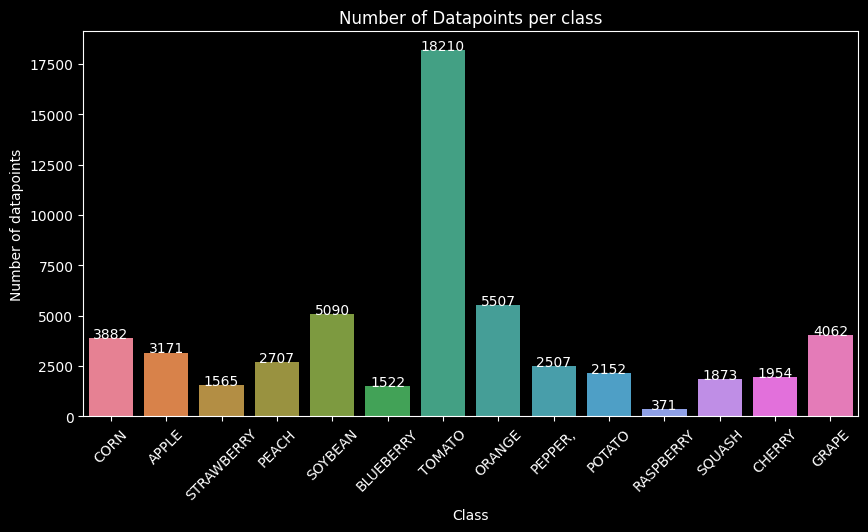

In [ ]:
# Plot histogram class vs number of datapoints
plt.figure(figsize=(10, 5))
sns.barplot(x=list_classes, y=list_datapoints, hue=list_classes)
plt.title('Number of Datapoints per class')
plt.xlabel('Class')
plt.ylabel('Number of datapoints')
plt.xticks(rotation=45)
# Draw number on top of bar
for i in range(len(list_classes)):
    plt.text(i, list_datapoints[i], list_datapoints[i], ha='center')
plt.show()

### Create Customized Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
pin_mem = True if device.type == "cuda" else False
print(pin_mem)

True


In [ ]:
class Dataset(torch.utils.data.Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, path, transform):
        # Initialization Validation Dataset
        data = ImageFolder(root=path, transform=transform)
        #print(data)
        self.species = get_species(data.classes)
        self.healthiness = get_healthiness(data.classes)
        self.health_states = [0, 1]
        self.targets = torch.zeros(len(data.imgs), 3)
        self.__get_target_species(self.species, self.targets)
        self.__get_target_healthiness(self.healthiness, self.targets)

    def __get_target_species(self, species, targets):
        # Get targets
        for i in range(len(species)):
            for k in range(len(data.imgs)):
                if (species[i].lower() in data.imgs[k][0] or species[i].lower().title() in data.imgs[k][0]):
                    targets[k][0] = i

    def __get_target_healthiness(self, healthiness, targets):
        # Get position in healthiness of HEALTHY
        for i in range(len(healthiness)):
            if (healthiness[i].lower() == 'healthy'):
                healthy_idx = i
                break
        # Get targets
        for i in range(len(healthiness)):
            for k in range(len(data.imgs)):
                if (healthiness[healthy_idx].lower() in data.imgs[k][0] or healthiness[healthy_idx].lower().title() in data.imgs[k][0]):
                    targets[k][1] = self.health_states[1]   # healthy (1)
                    targets[k][2] = healthy_idx   # no disease (healthy idx)
                else:
                    targets[k][1] = self.health_states[0]   # not healthy (0)
                    for j in range(len(healthiness)):
                        if j != healthy_idx:
                            if (healthiness[j].lower() in data.imgs[k][0] or healthiness[j].lower().title() in data.imgs[k][0]):
                                targets[k][2] = j   # disease (j) - does not include healthy idx

    def __len__(self):
        # Denotes the total number of samples
        return len(data.imgs)

    def __getitem__(self, index):
        # Select sample
        path_img = data.imgs[index][0]

        # Load data and get image (X)
        X = data.loader(path_img)
        X = transform(X)

        # Get targets as multi-hot encoded (14(species)+2(healthy state)+21(disease or healthy) classes)
        y_species = nn.functional.one_hot((self.targets[index][0]).to(torch.int64), num_classes=14)
        y_state = nn.functional.one_hot((self.targets[index][1]).to(torch.int64), num_classes=2)
        y_disease = nn.functional.one_hot((self.targets[index][2]).to(torch.int64), num_classes=21)

        # Convert to one-hot encoded
        y_species = y_species.to(torch.int64)
        y_state = y_state.to(torch.int64)
        y_disease = y_disease.to(torch.int64)

        # Returns species, state (unhealthy/healthy) and disease as one-hot encoded arrays for use with three different models
        return X, y_species, y_state, y_disease

In [ ]:
# Create Training Dataset
data_train = Dataset(path=path, transform=transform)

14
21


In [ ]:
# Verify correctness of a data point in new dataset
test_point = 4560
print(data_train.targets[test_point])
print(f"Species: {data_train.species[int(data_train.targets[test_point][0])]}")
print(f"Healthiness: {data_train.health_states[int(data_train.targets[test_point][1])]}")
print(f"Disease: {data_train.healthiness[int(data_train.targets[test_point][2])]}")

tensor([ 5.,  1., 18.])
Species: BLUEBERRY
Healthiness: 1
Disease: HEALTHY


In [ ]:
len(data.imgs)

54573

In [ ]:
# Create Data Loader for Training Dataset
data_loader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size=32, shuffle=True, num_workers=1)

In [ ]:
# Verify bacthing in Data Loader
batch_x, y_c, y_s, y_d = next(iter(data_loader_train))
print(batch_x[0], y_c[0], y_s[0], y_d[0])

tensor([[[1.4775, 1.4634, 1.4242,  ..., 0.9136, 1.0223, 1.2341],
         [1.5481, 1.5225, 1.4710,  ..., 0.9013, 1.0699, 1.1211],
         [1.6002, 1.5623, 1.5139,  ..., 0.9798, 1.2049, 1.0831],
         ...,
         [1.7523, 1.7753, 1.7604,  ..., 0.9774, 0.9748, 0.9147],
         [1.6459, 1.6882, 1.6905,  ..., 1.2772, 1.0067, 0.7605],
         [1.5470, 1.5894, 1.6111,  ..., 1.2330, 1.0288, 0.8170]]]) tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]) tensor([1, 0]) tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


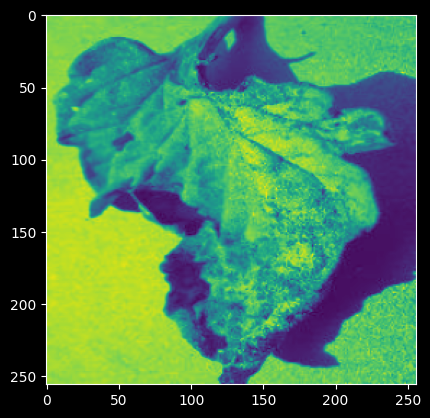

In [ ]:
plt.imshow(batch_x[0].permute(1, 2, 0))

## Create models

In [ ]:
from torchvision.models import densenet121, DenseNet121_Weights

In [ ]:
# Print model's state dict
#print("Model's state_dict:")
#for param_tensor in model_seg.state_dict():
#    print(param_tensor, "\t", model_seg.state_dict()[param_tensor].size())

# Print optimizer's state dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Import Variablae module pytorch
from torch.autograd import Variable

### 1. Species classification model

In [ ]:
from torchvision import models

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class ClasModelSpecies(nn.Module):
    def __init__(self):
        super(ClasModelSpecies, self).__init__()
        # Classification layer
        self.net_01 = models.densenet121(weights=DenseNet121_Weights.DEFAULT).to(device)
        self.net_01.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)
        self.net_01.classifier = nn.Linear(in_features=1024, out_features=14, bias=True).to(device)

    def forward(self, x):
        out_class = self.net_01(x)

        return out_class

In [ ]:
if training_mode:
    model_clas = ClasModelSpecies()

In [ ]:
if training_mode:
    next(model_clas.parameters()).is_cuda

In [ ]:
if training_mode:
    model_clas.to(device)

In [ ]:
#free cuda
torch.cuda.empty_cache()

In [ ]:
if training_mode:
    optim_clas = torch.optim.Adam(model_clas.parameters(), lr=0.0001)
    loss_class = nn.CrossEntropyLoss()

In [ ]:
#from time import sleep

In [ ]:
# Train model
if training_mode:
    def train_clas(model, epochs, batch_size, loss_fn, optimizer, checkpoint_path):
        loss_history = []
        val_loss_history = []
        img_not_fixed = True
        running_loss = 0.0
        weigths_species = torch.ones(14, dtype=torch.float32).to(device=device)
        weigths_species = weigths_species / torch.sum(weigths_species)
        weigths_species[TOMATO_idx] = weigths_species[TOMATO_idx] * 0.1
        weigths_species[RASPBERRY_idx] = weigths_species[RASPBERRY_idx] * 1.9

        for epoch in range(epochs):
            # Training
            model.train()
            print(f"{WHITE}Epoch {YELLOW}{epoch+1}{RESET} started")
            batch_x, batch_y_species, _, _ = next(iter(data_loader_train))
            print(f"{WHITE}Batch X: {YELLOW}{np.shape(batch_x)}{RESET}")

            # Get fixed image for printing
            if img_not_fixed:
                img = batch_x
                img_class = batch_y_species
                img_not_fixed = False


            # Clear out the gradient
            optimizer.zero_grad()

            # Forward pass through the network
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y_species = batch_y_species.to(device=device)

            output_class = model(batch_x)
            output_class = output_class.to(dtype=torch.float32)

            batch_x = batch_x.to('cpu')
            output_class = output_class.to('cpu')
            batch_y_species = batch_y_species.to('cpu')

            torch.cuda.empty_cache()

            # Calculate the loss
            loss_clas = loss_fn(output_class.to(dtype=torch.float32),
                            batch_y_species.to(dtype=torch.float32))
            loss_clas = loss_clas * weigths_species
            loss_clas = loss_clas.mean()
            print(f"{WHITE}Train Batch Loss (Species): {YELLOW}{loss_clas}{RESET}")

            # Compute the gradient
            loss_clas.backward()
            print(f"{WHITE}Train Batch Total Loss: {YELLOW}{loss_clas}{RESET}")

            # Update the weights
            optimizer.step()
            running_loss += loss_clas.item()
            loss_history.append((loss_clas.item(), running_loss))

            torch.cuda.empty_cache()

            with torch.no_grad():
                model.eval()
                pred_class = model(img.to(device).to(dtype=torch.float32))
                print(f"pred_class: {pred_class[0]}")

        # Save the model
        if checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path)

        plt.figure(figsize=(15, 8))
        plt.subplot(1, 2, 1)
        print(img[0].shape)
        plt.imshow(img[0].permute(1, 2, 0))
        plt.title(f"Image - Class: {img_class[0]}")
        #sleep(0.1)
        #plt.show()

        return loss_history

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Batch X: torch.Size([32, 1, 256, 256])
Train Batch Loss (Species): 0.03401320427656174
Train Batch Total Loss: 0.03401320427656174
pred_class: tensor([-2.0552, -0.9147, -1.0725, -1.0154, -0.9426, -1.2730,  6.3140, -2.4984,
        -0.0505, -0.0309, -0.7138, -1.1342, -1.0292,  0.4841], device='cuda:0')
Epoch 173 started
Batch X: torch.Size([32, 1, 256, 256])
Train Batch Loss (Species): 0.024038413539528847
Train Batch Total Loss: 0.024038413539528847
pred_class: tensor([-2.0331, -0.9526, -1.0859, -1.0639, -0.9419, -1.3276,  6.3692, -2.4474,
        -0.0546, -0.0506, -0.7109, -1.1235, -1.0036,  0.5564], device='cuda:0')
Epoch 174 started
Batch X: torch.Size([32, 1, 256, 256])
Train Batch Loss (Species): 0.018335070461034775
Train Batch Total Loss: 0.018335070461034775
pred_class: tensor([-2.0198, -0.9657, -1.0499, -1.0704, -0.9232, -1.3774,  6.3245, -2.4452,
        -0.0527, -0.0643, -0.6968, -1.1232, -0.9693, 

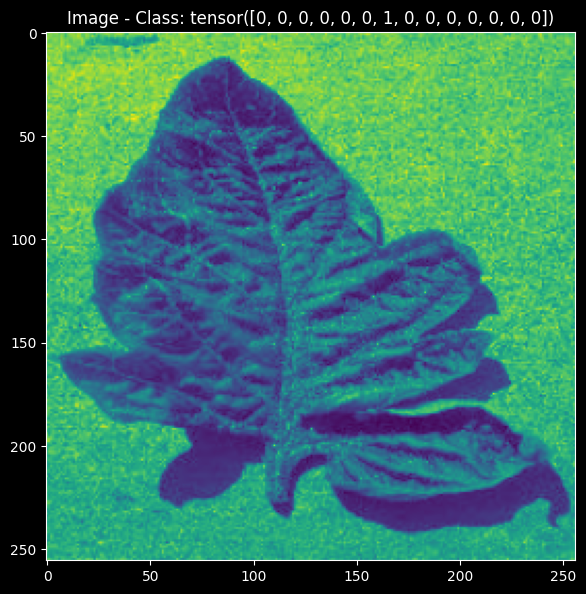

In [ ]:
# Start training
if training_mode:
    loss_history = train_clas(model_clas, 1000, 32, loss_class, optim_clas, 'model_cp_species_densenet')

In [ ]:
if training_mode:
    loss_history_loss = [loss_history[i][0] for i in range(len(loss_history))]

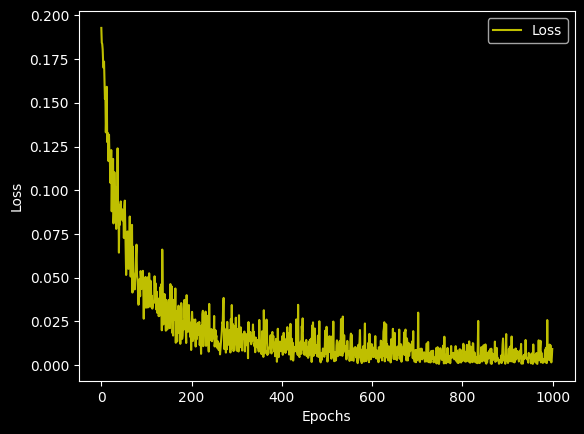

In [ ]:
if training_mode:
    # Plot losses vs epochs
    plt.plot(loss_history_loss, 'y')
    #plt.plot(val_loss_history, 'g--')
    plt.legend(['Loss'])#, 'Val Loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

#### Test model

In [ ]:
if training_mode and individual_testing:
    # Load model
    model_clas.load_state_dict(torch.load('model_cp_species_densenet'))

In [ ]:
if training_mode and individual_testing:
    data_loader_tst = torch.utils.data.DataLoader(dataset=data_train, batch_size=64, shuffle=True, num_workers=1)

In [ ]:
if training_mode and individual_testing:
    batch_x, batch_y_species, batch_y_state, batch_y_disease = next(iter(data_loader_tst))

In [ ]:
if training_mode and individual_testing:
    batch_x, batch_y_species, _, _ = next(iter(data_loader_tst))

In [ ]:
#batch_x.shape, batch_y_species.shape, batch_y_state.shape, batch_y_disease.shape

In [ ]:
if training_mode and individual_testing:
    model_clas.eval()

In [ ]:
if training_mode and individual_testing:
    pred_class = model_clas(batch_x.to(device).to(dtype=torch.float32))

In [ ]:
if training_mode and individual_testing:
    pred_class = torch.argmax(pred_class.softmax(dim=1), dim=1)

In [ ]:
if training_mode and individual_testing:
    target = torch.argmax(batch_y_species.to(device).to(dtype=torch.float32), dim=1)

In [ ]:
if training_mode and individual_testing:
    comparison = pred_class == target
    #comparison

In [ ]:
if training_mode and individual_testing:
    # Calculate accuracy
    total_samples = comparison.shape[0]
    correct = torch.count_nonzero(comparison)
    accuracy = (correct/total_samples)*100
    print(f"{WHITE}Accuracy: {YELLOW}{accuracy}%{RESET}")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
if training_mode and individual_testing:
    # Calculate accuracy for several batches
    accuracy_mean = 0.0
    accuracy_list = []
    for i in range(300):
        model_clas.eval()
        with torch.no_grad():
            batch_x, batch_y_species, _, _ = next(iter(data_loader_tst))
            pred_class = model_clas(batch_x.to(device).to(dtype=torch.float32))
            pred_class = torch.argmax(pred_class.softmax(dim=1), dim=1)
            target = torch.argmax(batch_y_species.to(device).to(dtype=torch.float32), dim=1)
            comparison = pred_class == target

            total_samples = comparison.shape[0]
            correct = torch.count_nonzero(comparison)
            accuracy = (correct/total_samples)*100
            accuracy_list.append(accuracy)
            print(f"{WHITE}Epoch: {i+1} - Accuracy Species: {YELLOW}{accuracy}%{RESET}")

            accuracy_mean += accuracy

    accuracy_mean /= 300
    print(f"{WHITE}Accuracy Species Mean: {YELLOW}{accuracy_mean}%{RESET}")


### 2. State classification model

In [ ]:
class ClasModelState(nn.Module):
    def __init__(self):
        super(ClasModelState, self).__init__()
        # Classification layer
        self.net_01 = models.densenet121(weights=DenseNet121_Weights.DEFAULT).to(device)
        self.net_01.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)
        self.net_01.classifier = nn.Linear(in_features=1024, out_features=2, bias=True).to(device)

    def forward(self, x):
        out_state = self.net_01(x)

        return out_state

In [ ]:
if training_mode:
    model_state = ClasModelState()

In [ ]:
if training_mode:
    model_state.to(device)

In [ ]:
if training_mode:
    next(model_state.parameters()).is_cuda

In [ ]:
#free cuda
torch.cuda.empty_cache()

In [ ]:
if training_mode:
    optim_state = torch.optim.Adam(model_state.parameters(), lr=0.0001)
    loss_state = nn.CrossEntropyLoss()

In [ ]:
# Train model
if training_mode:
    def train_state(model, epochs, batch_size, loss_fn, optimizer, checkpoint_path):
        loss_history = []
        val_loss_history = []
        img_not_fixed = True
        running_loss = 0.0
        weigths_state = torch.ones(2, dtype=torch.float32).to(device=device)
        weigths_state = weigths_state / torch.sum(weigths_state)

        for epoch in range(epochs):
            # Training
            model.train()
            print(f"{WHITE}Epoch {YELLOW}{epoch+1}{RESET} started")
            batch_x, _, batch_y_state, _ = next(iter(data_loader_train))
            print(f"{WHITE}Batch X: {YELLOW}{np.shape(batch_x)}{RESET}")

            # Get fixed image for printing
            if img_not_fixed:
                img = batch_x
                img_state = batch_y_state ## change to state
                img_not_fixed = False

            # Clear out the gradient
            optimizer.zero_grad()

            # Forward pass through the network
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y_state = batch_y_state.to(device=device)

            output_state = model(batch_x)
            output_state = output_state.to(dtype=torch.float32)

            batch_x = batch_x.to('cpu')
            output_state = output_state.to('cpu')
            batch_y_state = batch_y_state.to('cpu')

            torch.cuda.empty_cache()

            # Calculate the loss
            loss_state = loss_fn(output_state.to(dtype=torch.float32),
                            batch_y_state.to(dtype=torch.float32))
            loss_state = loss_state * weigths_state
            loss_state = loss_state.mean()
            print(f"{WHITE}Train Batch Loss (Species): {YELLOW}{loss_state}{RESET}")

            # Compute the gradient
            loss_state.backward()
            print(f"{WHITE}Train Batch Total Loss: {YELLOW}{loss_state}{RESET}")

            # Update the weights
            optimizer.step()
            running_loss += loss_state.item()
            loss_history.append((loss_state.item(), running_loss))

            torch.cuda.empty_cache()

            with torch.no_grad():
                model.eval()
                pred_state = model(img.to(device).to(dtype=torch.float32))
                print(f"pred_state: {pred_state[0]}")

        # Save the model
        if checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path)

        plt.figure(figsize=(15, 8))
        plt.subplot(1, 2, 1)
        print(img[0].shape)
        plt.imshow(img[0].permute(1, 2, 0))
        plt.title(f"Image - Class: {img_state[0]}")
        #sleep(0.1)
        #plt.show()

        return loss_history

Epoch 1 started
Batch X: torch.Size([32, 1, 256, 256])
Train Batch Loss (Species): 0.3690871000289917
Train Batch Total Loss: 0.3690871000289917
pred_state: tensor([0.8445, 0.1732], device='cuda:0')
Epoch 2 started
Batch X: torch.Size([32, 1, 256, 256])
Train Batch Loss (Species): 0.2835479974746704
Train Batch Total Loss: 0.2835479974746704
pred_state: tensor([0.8831, 0.2215], device='cuda:0')
Epoch 3 started
Batch X: torch.Size([32, 1, 256, 256])
Train Batch Loss (Species): 0.2657936215400696
Train Batch Total Loss: 0.2657936215400696
pred_state: tensor([0.9216, 0.1970], device='cuda:0')
Epoch 4 started
Batch X: torch.Size([32, 1, 256, 256])
Train Batch Loss (Species): 0.20159834623336792
Train Batch Total Loss: 0.20159834623336792
pred_state: tensor([0.9371, 0.1603], device='cuda:0')
Epoch 5 started
Batch X: torch.Size([32, 1, 256, 256])
Train Batch Loss (Species): 0.1883751004934311
Train Batch Total Loss: 0.1883751004934311
pred_state: tensor([0.9284, 0.1399], device='cuda:0')
Epo

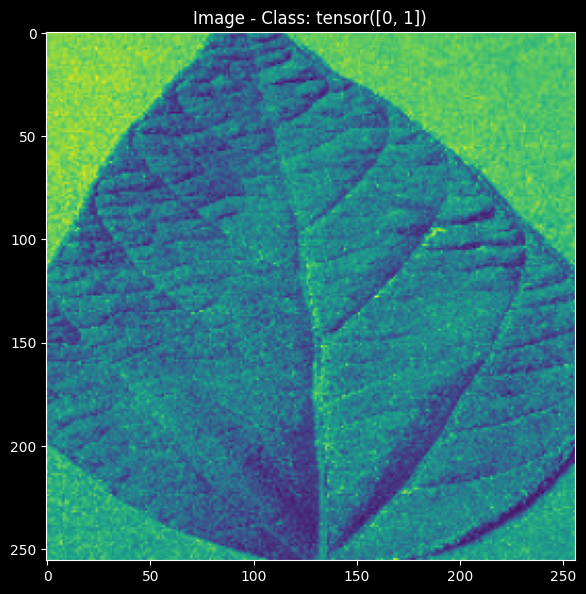

In [ ]:
if training_mode:
    # Start training
    loss_history_state = train_state(model_state, 100, 10, loss_state, optim_state, 'model_cp_state_densenet')

In [ ]:
if training_mode:
    loss_history_state_loss = [loss_history_state[i][0] for i in range(len(loss_history_state))]

In [ ]:
if training_mode:
    # Plot losses vs epochs
    plt.plot(loss_history_state_loss, 'y')
    #plt.plot(val_loss_history, 'g--')
    plt.legend(['Loss'])#, 'Val Loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

#### Test model



In [ ]:
if training_mode and individual_testing:
    data_loader_tst = torch.utils.data.DataLoader(dataset=data_train, batch_size=64, shuffle=True, num_workers=1)

In [ ]:
if training_mode and individual_testing:
    batch_x, _, batch_y_state, _ = next(iter(data_loader_tst))

In [ ]:
if training_mode and individual_testing:
    model_state.eval()

In [ ]:
if training_mode and individual_testing:
    pred_state = model_state(batch_x.to(device).to(dtype=torch.float32))

In [ ]:
if training_mode and individual_testing:
    pred_state = torch.argmax(pred_state.softmax(dim=1), dim=1)

In [ ]:
if training_mode and individual_testing:
    target = torch.argmax(batch_y_state.to(device).to(dtype=torch.float32), dim=1)

In [ ]:
if training_mode and individual_testing:
    comparison = pred_state == target
    #comparison

In [ ]:
if training_mode and individual_testing:
    # Calculate accuracy
    total_samples = comparison.shape[0]
    correct = torch.count_nonzero(comparison)
    accuracy = (correct/total_samples)*100
    print(f"{WHITE}Accuracy: {YELLOW}{accuracy}%{RESET}")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
if training_mode and individual_testing:
    # Calculate accuracy for several batches
    accuracy_state_mean = 0.0
    accuracy_state_list = []
    for i in range(100):
        model_state.eval()
        with torch.no_grad():
            batch_x, _, batch_y_state, _ = next(iter(data_loader_tst))
            pred_state = model_state(batch_x.to(device).to(dtype=torch.float32))
            pred_state = torch.argmax(pred_state.softmax(dim=1), dim=1)
            target = torch.argmax(batch_y_state.to(device).to(dtype=torch.float32), dim=1)
            comparison = pred_state == target

            total_samples = comparison.shape[0]
            correct = torch.count_nonzero(comparison)
            accuracy = (correct/total_samples)*100
            accuracy_state_list.append(accuracy)
            print(f"{WHITE}Epoch: {i+1} - Accuracy State: {YELLOW}{accuracy}%{RESET}")

            accuracy_state_mean += accuracy

    accuracy_state_mean /= 300
    print(f"{WHITE}Accuracy State Mean: {YELLOW}{accuracy_state_mean}%{RESET}")


### Disease classification model

In [ ]:
class ClasModelDisease(nn.Module):
    def __init__(self):
        super(ClasModelDisease, self).__init__()
        # Classification layer
        self.net_01 = models.densenet121(weights=DenseNet121_Weights.DEFAULT).to(device)
        self.net_01.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)
        self.net_01.classifier = nn.Linear(in_features=1024, out_features=21, bias=True).to(device)

    def forward(self, x):
        out_disease = self.net_01(x)

        return out_disease

In [ ]:
if training_mode:
    model_disease = ClasModelDisease()

In [ ]:
if training_mode:
    model_disease = model_disease.to(device)

In [ ]:
if training_mode:
    next(model_state.parameters()).is_cuda

In [ ]:
#free cuda
torch.cuda.empty_cache()

In [ ]:
if training_mode:
    optim_disease = torch.optim.Adam(model_disease.parameters(), lr=0.0001)
    loss_disease = nn.CrossEntropyLoss()

In [ ]:
# Train model
if training_mode:

    def train_disease(model, epochs, batch_size, loss_fn, optimizer, checkpoint_path):
        loss_history = []
        val_loss_history = []
        img_not_fixed = True
        running_loss = 0.0
        weigths_disease = torch.ones(2, dtype=torch.float32).to(device=device)
        weigths_disease = weigths_disease / torch.sum(weigths_disease)

        for epoch in range(epochs):
            # Training
            model.train()
            print(f"{WHITE}Epoch {YELLOW}{epoch+1}{RESET} started")
            batch_x, _, _, batch_y_disease = next(iter(data_loader_train))
            print(f"{WHITE}Batch X: {YELLOW}{np.shape(batch_x)}{RESET}")

            # Get fixed image for printing
            if img_not_fixed:
                img = batch_x
                img_disease = batch_y_disease ## change to state
                img_not_fixed = False

            # Clear out the gradient
            optimizer.zero_grad()

            # Forward pass through the network
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y_disease = batch_y_disease.to(device=device)

            output_disease = model(batch_x)
            output_disease = output_disease.to(dtype=torch.float32)

            batch_x = batch_x.to('cpu')
            output_disease = output_disease.to('cpu')
            batch_y_disease = batch_y_disease.to('cpu')

            torch.cuda.empty_cache()

            # Calculate the loss
            loss_disease = loss_fn(output_disease.to(dtype=torch.float32),
                            batch_y_disease.to(dtype=torch.float32))
            loss_disease = loss_disease * weigths_disease
            loss_disease = loss_disease.mean()
            print(f"{WHITE}Train Batch Loss (Species): {YELLOW}{loss_disease}{RESET}")

            # Compute the gradient
            loss_disease.backward()
            print(f"{WHITE}Train Batch Total Loss: {YELLOW}{loss_disease}{RESET}")

            # Update the weights
            optimizer.step()
            running_loss += loss_disease.item()
            loss_history.append((loss_disease.item(), running_loss))

            torch.cuda.empty_cache()

            with torch.no_grad():
                model.eval()
                pred_disease = model(img.to(device).to(dtype=torch.float32))
                print(f"pred_disease: {pred_disease[0]}")

        # Save the model
        if checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path)

        plt.figure(figsize=(15, 8))
        plt.subplot(1, 2, 1)
        print(img[0].shape)
        plt.imshow(img[0].permute(1, 2, 0))
        plt.title(f"Image - Class: {img_disease[0]}")
        #sleep(0.1)
        #plt.show()

        return loss_history

Epoch 1 started
Batch X: torch.Size([32, 1, 256, 256])
Train Batch Loss (Species): 1.5457539558410645
Train Batch Total Loss: 1.5457539558410645
pred_disease: tensor([ 0.1929,  0.3348, -0.0879, -0.2869, -0.4328,  0.1139,  0.1647,  0.6653,
        -0.6657, -0.2974, -0.4639,  0.4967,  0.0756, -0.5457, -0.3019, -0.3055,
        -1.3508,  0.2039, -0.4707,  0.0832,  0.5694], device='cuda:0')
Epoch 2 started
Batch X: torch.Size([32, 1, 256, 256])
Train Batch Loss (Species): 1.5458741188049316
Train Batch Total Loss: 1.5458741188049316
pred_disease: tensor([ 0.2254,  0.2920, -0.0524, -0.2941, -0.4324,  0.1685,  0.0447,  0.6291,
        -0.6494, -0.2372, -0.3675,  0.5272,  0.0351, -0.5783, -0.3217, -0.3678,
        -1.3064,  0.1750, -0.4210, -0.0707,  0.4695], device='cuda:0')
Epoch 3 started
Batch X: torch.Size([32, 1, 256, 256])
Train Batch Loss (Species): 1.451006531715393
Train Batch Total Loss: 1.451006531715393
pred_disease: tensor([ 0.2114,  0.2140, -0.0796, -0.2476, -0.4156,  0.2030, -

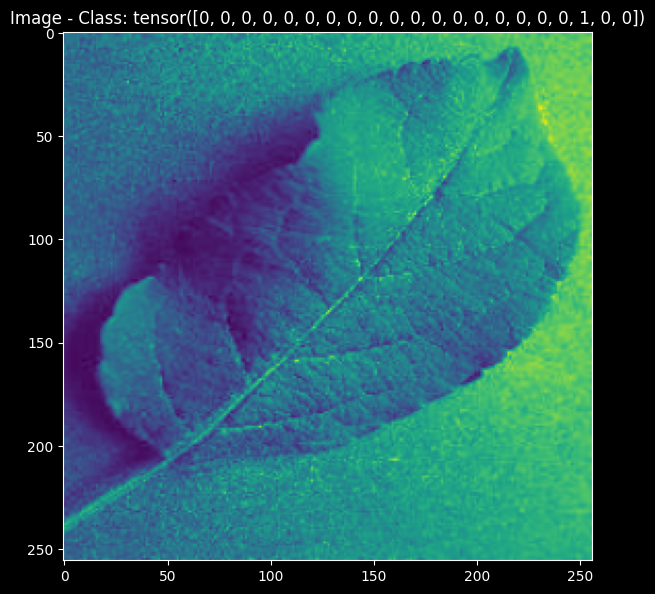

In [ ]:
if training_mode:
    # Start training
    loss_history_disease = train_disease(model_disease, 400, 32, loss_disease, optim_disease, 'model_cp_disease_densenet')

In [ ]:
if training_mode:
    loss_history_disease_loss = [loss_history_disease[i][0] for i in range(len(loss_history_disease))]

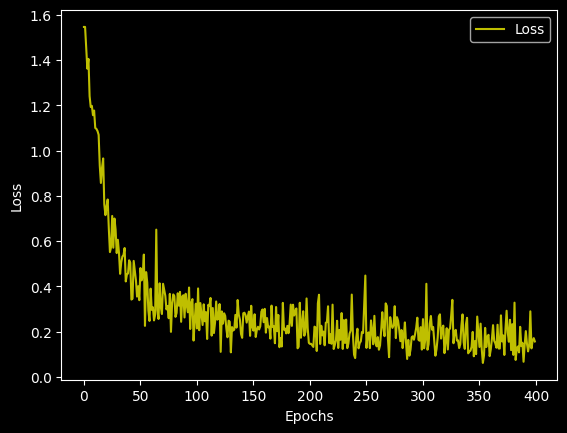

In [ ]:
if training_mode:
    # Plot losses vs epochs
    plt.plot(loss_history_disease_loss, 'y')
    #plt.plot(val_loss_history, 'g--')
    plt.legend(['Loss'])#, 'Val Loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

#### Test model

In [ ]:
if training_mode and individual_testing:
    data_loader_tst = torch.utils.data.DataLoader(dataset=data_train, batch_size=64, shuffle=True, num_workers=1)

In [ ]:
if training_mode and individual_testing:
    batch_x, _, _, batch_y_disease = next(iter(data_loader_tst))

In [ ]:
if training_mode and individual_testing:
    model_disease.eval()

In [ ]:
if training_mode and individual_testing:
    pred_disease = model_disease(batch_x.to(device).to(dtype=torch.float32))

In [ ]:
if training_mode and individual_testing:
    pred_disease = torch.argmax(pred_disease.softmax(dim=1), dim=1)

In [ ]:
if training_mode and individual_testing:
    target = torch.argmax(batch_y_disease.to(device).to(dtype=torch.float32), dim=1)

In [ ]:
if training_mode and individual_testing:
    comparison = pred_disease == target
    #comparison

In [ ]:
if training_mode and individual_testing:
    # Calculate accuracy
    total_samples = comparison.shape[0]
    correct = torch.count_nonzero(comparison)
    accuracy = (correct/total_samples)*100
    print(f"{WHITE}Accuracy: {YELLOW}{accuracy}%{RESET}")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
if training_mode and individual_testing:
    # Calculate accuracy for several batches
    accuracy_disease_mean = 0.0
    accuracy_disease_list = []
    for i in range(100):
        model_state.eval()
        with torch.no_grad():
            batch_x, _, _, batch_y_disease = next(iter(data_loader_tst))
            pred_disease = model_disease(batch_x.to(device).to(dtype=torch.float32))
            pred_disease = torch.argmax(pred_disease.softmax(dim=1), dim=1)
            target = torch.argmax(batch_y_disease.to(device).to(dtype=torch.float32), dim=1)
            comparison = pred_disease == target

            total_samples = comparison.shape[0]
            correct = torch.count_nonzero(comparison)
            accuracy = (correct/total_samples)*100
            accuracy_disease_list.append(accuracy)
            print(f"{WHITE}Epoch: {i+1} - Accuracy Disease: {YELLOW}{accuracy}%{RESET}")

            accuracy_disease_mean += accuracy

    accuracy_disease_mean /= 300
    print(f"{WHITE}Accuracy Disease Mean: {YELLOW}{accuracy_disease_mean}%{RESET}")


### Combined accuracy

In [ ]:
# Instantiate models for three classification problems
model_clas = ClasModelSpecies()
model_state = ClasModelState()
model_disease = ClasModelDisease()

In [ ]:
# Load weights from previous training
model_clas.load_state_dict(torch.load('model_cp_species_densenet'))
model_state.load_state_dict(torch.load('model_cp_state_densenet'))
model_disease.load_state_dict(torch.load('model_cp_disease_densenet'))

<All keys matched successfully>

In [ ]:
# Free GPU RAM
torch.cuda.empty_cache()

In [ ]:
# Create TST data loader
data_loader_tst = torch.utils.data.DataLoader(dataset=data_train, batch_size=64, shuffle=True, num_workers=1)

In [ ]:
# Get batches (Images and targets(3 classifications))
batch_x, batch_y_species, batch_y_state, batch_y_disease = next(iter(data_loader_tst))

In [ ]:
# Load model to GPU
model_clas.to(device)
model_state.to(device)
model_disease.to(device)

ClasModelDisease(
  (net_01): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [ ]:
# Set model to eval state
model_clas.eval()
model_state.eval()
model_disease.eval()

ClasModelDisease(
  (net_01): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [ ]:
# Get predictions for previously trained models
with torch.no_grad():
    pred_species = model_clas(batch_x.to(device).to(dtype=torch.float32))
    pred_state = model_state(batch_x.to(device).to(dtype=torch.float32))
    pred_disease = model_disease(batch_x.to(device).to(dtype=torch.float32))

In [ ]:
# Apply softmax
pred_species = pred_species.softmax(dim=1)
pred_state = pred_state.softmax(dim=1)
pred_disease = pred_disease.softmax(dim=1)

In [ ]:
# Get positions for predicted species (14), state (unhealthy/healthy), disease (21)
pred_species = torch.argmax(pred_species.softmax(dim=1), dim=1)
pred_state = torch.argmax(pred_state.softmax(dim=1), dim=1)
pred_disease = torch.argmax(pred_disease.softmax(dim=1), dim=1)

In [ ]:
# Get positions in targets to compare with predicted classes
batch_y_species = torch.argmax(batch_y_species.to(device).to(dtype=torch.float32), dim=1)
batch_y_state = torch.argmax(batch_y_state.to(device).to(dtype=torch.float32), dim=1)
batch_y_disease = torch.argmax(batch_y_disease.to(device).to(dtype=torch.float32), dim=1)

In [ ]:
comp_species = pred_species == batch_y_species

In [ ]:
comp_state = pred_state == batch_y_state

In [ ]:
comp_disease = pred_disease == batch_y_disease

In [ ]:
a = comp_species.reshape(comp_species.shape[0], 1)

In [ ]:
b = comp_state.reshape(comp_state.shape[0], 1)

In [ ]:
c = comp_disease.reshape(comp_disease.shape[0], 1)

In [ ]:
a.shape, b.shape, c.shape

(torch.Size([64, 1]), torch.Size([64, 1]), torch.Size([64, 1]))

In [ ]:
# Concat comparisons column-wise where each row has predictions comparisons against targets for an image in the batch
# Colum 1: Species
# Colum 2: State
# Colum 3: Disease
concat = torch.cat(([a, b, c]), dim=1)
concat[63]

tensor([True, True, True], device='cuda:0')

In [ ]:
concat.shape

torch.Size([64, 3])

In [ ]:
# Example on how-to interpret the concat array
print(f"{WHITE}Example Batch {63}: \
        {RESET}\nSpecies OK? {YELLOW}{concat[63][0]} \
        {RESET}\nState OK? {YELLOW}{concat[63][1]} \
        {RESET}\nDisease OK? {YELLOW}{concat[63][2]} \
        {RESET}")

Example Batch 63:         
Species OK? True         
State OK? True         
Disease OK? True         


In [ ]:
# General (three models results) Accuracy for one batch
count_list = []
for i in range(concat.shape[0]):
    count = torch.count_nonzero(concat[i])/concat.shape[1]
    count_list.append(count)
avg_count = sum(count_list)/len(count_list)
avg_count *= 100

print(f"{WHITE}Accuracy Classification: {YELLOW}{avg_count:.2f}%{RESET}")

Accuracy Classification: 94.27%


In [ ]:
# Calculate accuracy per column
accuracy_species = torch.count_nonzero(concat[:, 0])/concat.shape[0]
accuracy_species *= 100
print(f"{WHITE}Accuracy (Batch) Species: {YELLOW}{accuracy_species:.2f}%{RESET}")

accuracy_state = torch.count_nonzero(concat[:, 1])/concat.shape[0]
accuracy_state *= 100
print(f"{WHITE}Accuracy (Bacth) State: {YELLOW}{accuracy_state:.2f}%{RESET}")

accuracy_disease = torch.count_nonzero(concat[:, 2])/concat.shape[0]
accuracy_disease *= 100
print(f"{WHITE}Accuracy (Bacth) Disease: {YELLOW}{accuracy_disease:.2f}%{RESET}")

Accuracy (Batch) Species: 100.00%
Accuracy (Bacth) State: 92.19%
Accuracy (Bacth) Disease: 90.62%
